## Latent Diffusion Simple
### [CelebA]

In [1]:
from model.DiffusionModules import UNet, EMA
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from model.vae_conv import VAE
import torch.nn.functional as F
from pytorch_model_summary import summary
import torchvision.datasets as dset
import cv2, math
import copy

/home/sha/anaconda3/envs/dvaa/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


make directories

In [2]:
if not os.path.exists(f"weight"):
    os.makedirs(f"weight")
if not os.path.exists(f"content"):
    os.makedirs(f"content")
if not os.path.exists(f"weight/ldm_celeba"):
    os.makedirs(f"weight/ldm_celeba")
if not os.path.exists(f"content/ldm_celeba"):
    os.makedirs(f"content/ldm_celeba")

Image Function (input: tensor)

In [2]:
def imshow(img, gray=False, size=2):
    '''
    input: tensor [3, h, w]
    '''
    d_img = img.permute(1,2,0).numpy()
    d_img = (d_img * 255).astype('uint8')
    plt.figure(figsize=(size,size))   
    if gray:
        plt.imshow(d_img, cmap='gray')
    else:
        plt.imshow(d_img)
    plt.axis('off')
    plt.show()

## Training Process

GPU check

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Dataset Loading

In [4]:
batch_size = 256
rsl = 64
dataroot = "data/celeba"

In [5]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize((rsl, rsl)),
                               transforms.ToTensor()
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True)

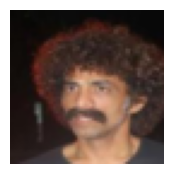

In [6]:
dataiter = iter(dataloader)
images, labels = next(dataiter)
image = images[0]

imshow(image)

In [8]:
print(torch.min(image), torch.max(image))

tensor(0.0588) tensor(0.9882)


Load VAE

In [7]:
img_res = 64
img_cnl = 3
latent_cnl = 8

SAVED_PATH = '/home/sha/medical_system/ldm/weight/vae_celeba/conv_vae_20000iter.pth'

In [8]:
vae = VAE(img_res, img_cnl, latent_cnl).to(device)

try:
    vae.load_state_dict(torch.load(SAVED_PATH))
    vae.eval()
    for params in vae.parameters():
        params.requires_grad = False
    print('load frozen model ok!')
except:
    print('error')

load frozen model ok!


input[0].shape: torch.Size([3, 64, 64])


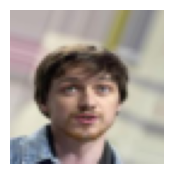

z[0].shape: torch.Size([8, 8, 8])


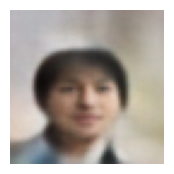

output[0].shape: torch.Size([3, 64, 64])


In [11]:
for data in dataloader:
    input, _ = data
    input = input.to(device)

    # input show
    print('input[0].shape:', input[0].shape)
    imshow(input[0].cpu().detach())

    # forward
    mu, logvar = vae.encode(input)
    z = vae.reparameterize(mu, logvar)    
    print('z[0].shape:', z[0].shape)
    output = vae.decode(z)

    # output show
    imshow(output[0].cpu().detach())
    print('output[0].shape:', output[0].shape)
    break

Define Diffusion Model

In [12]:
in_res=rsl//8
in_cnl=8
time_dim=256

In [13]:
model = UNet(c_in=in_cnl, c_out=in_cnl, time_dim=time_dim).to(device)
model.train()

x = torch.ones([batch_size, in_cnl, in_res, in_res]).cuda()
t = torch.ones([batch_size]).cuda()

print(summary(model,x,t))
print('input:',x.shape,t.shape)
print('output:',model(x,t).shape)
print('===================================')

-------------------------------------------------------------------------
       Layer (type)         Output Shape         Param #     Tr. Param #
       DoubleConv-1      [256, 64, 8, 8]          41,728          41,728
             Down-2     [256, 128, 4, 4]         328,576         328,576
    SelfAttention-3     [256, 128, 4, 4]          99,584          99,584
             Down-4     [256, 256, 2, 2]       1,246,976       1,246,976
    SelfAttention-5     [256, 256, 2, 2]         395,776         395,776
             Down-6     [256, 256, 1, 1]       2,427,136       2,427,136
    SelfAttention-7     [256, 256, 1, 1]         395,776         395,776
       DoubleConv-8     [256, 512, 1, 1]       3,540,992       3,540,992
       DoubleConv-9     [256, 512, 1, 1]       4,720,640       4,720,640
      DoubleConv-10     [256, 256, 1, 1]       1,770,496       1,770,496
              Up-11     [256, 128, 2, 2]       6,228,864       6,228,864
   SelfAttention-12     [256, 128, 2, 2]          

Define EMA Model

In [14]:
ema = EMA(0.995)
ema_model = copy.deepcopy(model).eval().requires_grad_(False)

Diffusion Model Parameters

In [9]:
def beta_schedule(timesteps=1000, linear=True):
    scale = 1000 / timesteps
    if linear: 
        beta_start = scale * 0.0001
        beta_end = scale * 0.01
        return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float32)
    # quadratic 
    else:
        beta_start = (scale * 0.0001)**0.5
        beta_end = (scale * 0.01)**0.5
        return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float32)**2

In [10]:
beta_list = beta_schedule(timesteps=1000, linear=True)
alpha_list = 1.0 - beta_list
alpha_bar_list = torch.cumprod(alpha_list, dim=0)

sqrt_alpha_bar_list = torch.sqrt(alpha_bar_list)
sqrt_one_minus_alpha_bar_list = torch.sqrt(1.0 - alpha_bar_list)
one_div_sqrt_alpha_list = 1.0 / torch.sqrt(alpha_list)

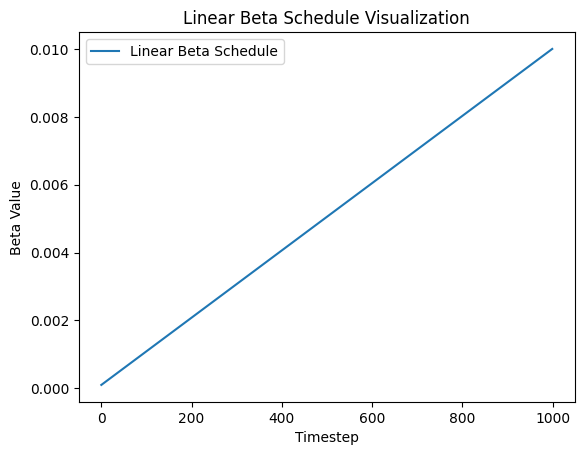

In [17]:
plt.plot(beta_list.numpy(), label='Linear Beta Schedule')
plt.xlabel('Timestep')
plt.ylabel('Beta Value')
plt.title('Linear Beta Schedule Visualization')
plt.legend()
plt.show()

Training Setting

In [11]:
learning_rate = 1e-4
epochs = 50
timestep_num = 1000
save_epoch = 1

Set loss function and Optimizer

In [19]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-5)
sch = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(dataloader), epochs=epochs)
scaler = torch.cuda.amp.GradScaler()
losses = []

Sampling Setting

In [20]:
width_num = int(math.sqrt(batch_size))
height_num = int(math.sqrt(batch_size))
total_num = width_num * height_num

if total_num > 100:
    width_num = height_num = 10
    total_num = 100

print('width_num, height_num, total_num:',width_num, height_num, total_num)

width_num, height_num, total_num: 10 10 100


Setting Path

In [21]:
SAVE_PATH = './weight/ldm_celeba/ldm'
LAST_SAVE_PATH = './weight/ldm_celeba/ldm.pth'
CONTENT_PATH = './content/ldm_celeba/ldm'

Training

In [ ]:
print('-------------------------------------------------------------------')
print("Training Start")
print('-------------------------------------------------------------------\n')

epoch = 0 

for epoch in range(epochs):
    running_loss = 0.0
    val_running_loss = 0.0

    for iter, data in enumerate(dataloader, 0):
        input, _ = data
        input = input.to(device)

        # VAE Encoding
        mu, logvar = vae.encode(input)
        input = vae.reparameterize(mu, logvar) 
        data_size = len(input)

        # get time
        t = torch.randint(0, timestep_num, size=(data_size,), device=input.device).long()

        # forward process
        esp = torch.randn_like(input).to(device)
        noise_img = torch.zeros((data_size, in_cnl, in_res, in_res), dtype=torch.float32).to(device)
        for i in range(data_size):
            alpha_bar = sqrt_alpha_bar_list[t[i]]
            one_minus_alpha_bar = sqrt_one_minus_alpha_bar_list[t[i]]
            noise_img[i] = alpha_bar * input[i] + one_minus_alpha_bar * esp[i]

        # reverse process
        output = model(noise_img, t)
        loss = criterion(output, esp)
        running_loss += loss.item()

        # optimization
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        ema.step_ema(ema_model, model) # EMA for stable training
        sch.step()

        # check loss per 50 iteration
        if (iter+1) % 50 == 0:
            print(f"[{iter+1}] Loss: {loss.item()}")
    
    # record training loss
    losses.append(running_loss / len(dataloader))
    print('-------------------------------------------------------------------')
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(dataloader)}")

    # save model per [save_epoch] epoch
    if (epoch+1) % save_epoch == 0:
        torch.save(model.state_dict(), SAVE_PATH+f'_{epoch+1}epoch.pth')
        print('<< model save at [%d] epoch! >>' % (epoch+1))

        '''
        ==========================================
        Save Image (DDPM Sampling -> VAE Decoding)
        ==========================================
        '''
        out_img = np.zeros((img_res*height_num, img_res*width_num, 3)) # [in_res*h_num, in_res*w_num, 3]
        model.eval()

        with torch.no_grad():
            # get first z (noise)
            g_z = torch.randn((total_num, in_cnl, in_res, in_res), dtype=torch.float32).to(device)
                
            # DDPM Sampling 
            for time in range(timestep_num - 1, -1, -1): # 999 ~ 0 => 1000 step to 1 step 
                in_t = torch.full((total_num,), time, dtype=torch.long).to(device)

                # forward 
                pred_noise = model(g_z, in_t)

                # get t-th images 
                if time > 0:
                    z = torch.randn((total_num, in_cnl, in_res, in_res), dtype=torch.float32).to(device) 
                else:
                    z = torch.zeros_like(g_z).to(device)
                mu = one_div_sqrt_alpha_list[time] * (g_z - (beta_list[time] / sqrt_one_minus_alpha_bar_list[time]) * pred_noise)
                g_z = mu + (torch.sqrt(beta_list[time])*z)

            # VAE Decoding
            generated = vae.decode(g_z)

            np_g = generated.permute(0,2,3,1).cpu().detach().numpy()  # [total_num, img_res, img_res, 3]
            rs_img = np.resize(np_g, (height_num, width_num, img_res, img_res, 3)) # [h_num, w_num, img_res, img_res, 3]

            # make numpy images to grid image
            for i in range(height_num):
                for j in range(width_num):
                    out_img[i * img_res:i * img_res +img_res, j * img_res:j * img_res +img_res, 0] = rs_img[i, j, :, :, 0]
                    out_img[i * img_res:i * img_res +img_res, j * img_res:j * img_res +img_res, 1] = rs_img[i, j, :, :, 1]
                    out_img[i * img_res:i * img_res +img_res, j * img_res:j * img_res +img_res, 2] = rs_img[i, j, :, :, 2]

            file_path = CONTENT_PATH + f"_epoch_{epoch+1}.png"
            save_img = (out_img * 255).astype('uint8')
            save_img = cv2.cvtColor(save_img, cv2.COLOR_BGR2RGB)
            cv2.imwrite(file_path, save_img)

            model.train()

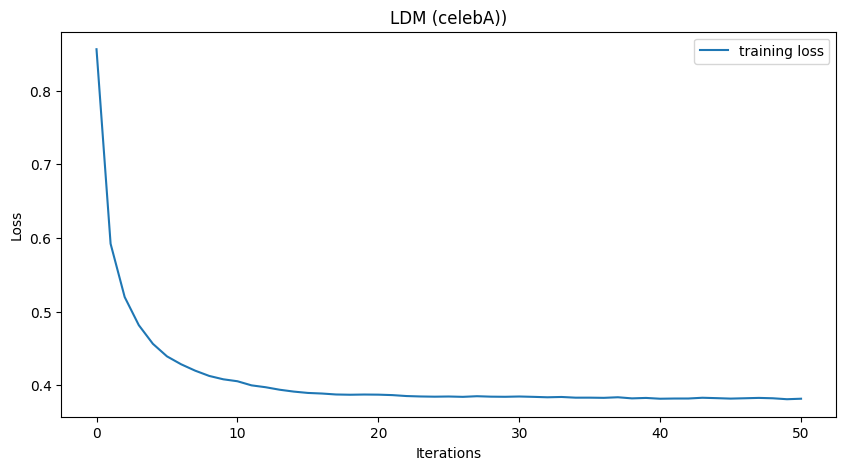

In [23]:
plt.figure(figsize=(10,5))
plt.title("LDM (celebA))")
plt.plot(losses,label="training loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Generating Process

model

In [17]:
in_res=rsl//8
in_cnl=8
time_dim=256

SAVED_PATH = '/home/sha/medical_system/ldm/weight/ldm_celeba/ldm_50epoch.pth'
CONTENT_PATH = './content/ldm_celeba/ldm'

In [18]:
model = UNet(c_in=in_cnl, c_out=in_cnl, time_dim=time_dim).to(device)

try:
    model.load_state_dict(torch.load(SAVED_PATH))
    model.eval()
    print('load model ok!')
except:
    print('error')

load model ok!


In [35]:
width_num = 6
height_num = 6
total_num = width_num * height_num

print('width_num, height_num, total_num:',width_num, height_num, total_num)

width_num, height_num, total_num: 6 6 36


DDPM Sampling

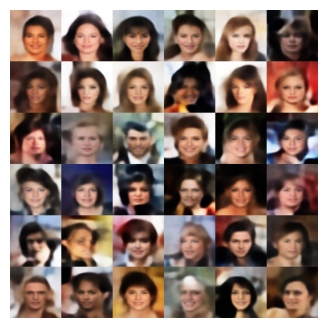

save ok!


In [46]:
out_img = np.zeros((img_res*height_num, img_res*width_num, 3)) # [in_res*h_num, in_res*w_num, 3]
model.eval()

with torch.no_grad():
    # get first z (noise)
    g_z = torch.randn((total_num, in_cnl, in_res, in_res), dtype=torch.float32).to(device)
        
    # DDPM Sampling 
    for time in range(timestep_num - 1, -1, -1): # 999 ~ 0 => 1000 step to 1 step 
        in_t = torch.full((total_num,), time, dtype=torch.long).to(device)

        # forward 
        pred_noise = model(g_z, in_t)

        # get t-th images 
        if time > 0:
            z = torch.randn((total_num, in_cnl, in_res, in_res), dtype=torch.float32).to(device) 
        else:
            z = torch.zeros_like(g_z).to(device)
        mu = one_div_sqrt_alpha_list[time] * (g_z - (beta_list[time] / sqrt_one_minus_alpha_bar_list[time]) * pred_noise)
        g_z = mu + (torch.sqrt(beta_list[time])*z)

    # VAE Decoding
    generated = vae.decode(g_z)

np_g = generated.permute(0,2,3,1).cpu().detach().numpy()  # [total_num, img_res, img_res, 3]
rs_img = np.resize(np_g, (height_num, width_num, img_res, img_res, 3)) # [h_num, w_num, img_res, img_res, 3]

# make numpy images to grid image
for i in range(height_num):
    for j in range(width_num):
        out_img[i * img_res:i * img_res +img_res, j * img_res:j * img_res +img_res, 0] = rs_img[i, j, :, :, 0]
        out_img[i * img_res:i * img_res +img_res, j * img_res:j * img_res +img_res, 1] = rs_img[i, j, :, :, 1]
        out_img[i * img_res:i * img_res +img_res, j * img_res:j * img_res +img_res, 2] = rs_img[i, j, :, :, 2]

# show
show = torch.from_numpy(out_img).permute(2,0,1) 
imshow(show, size=4)

# save
file_path = CONTENT_PATH + f"_ddpm_sample.png"
save_img = (out_img * 255).astype('uint8')
save_img = cv2.cvtColor(save_img, cv2.COLOR_BGR2RGB)
cv2.imwrite(file_path, save_img)
print('save ok!')

DDIM Sampling

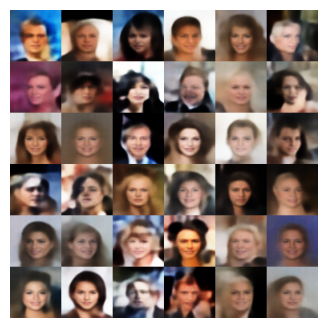

save ok!


In [56]:
out_img = np.zeros((img_res*height_num, img_res*width_num, 3)) # [in_res*h_num, in_res*w_num, 3]
model.eval()

with torch.no_grad():
    # get first z (noise)
    g_z = torch.randn((total_num, in_cnl, in_res, in_res), dtype=torch.float32).to(device)
        
    # get time_pairs 
    sampling_timesteps = 100
    times = torch.linspace(-1, timestep_num - 1, steps = sampling_timesteps + 1)   # [-1, 0, 1, 2, ..., T-1] when sampling_timesteps == total_timesteps
    times = list(reversed(times.int().tolist()))
    time_pairs = list(zip(times[:-1], times[1:])) # [(T-1, T-2), (T-2, T-3), ..., (1, 0), (0, -1)]

    # DDIM Sampling 
    for time, time_next in time_pairs:
        in_t = torch.full((total_num,), time, dtype=torch.long).to(device)

        # forward 
        pred_noise = model(g_z, in_t)

        # set alpha
        alpha = alpha_bar_list[time]
        alpha_next = alpha_bar_list[time_next]
        sqrt_alpha = torch.sqrt(alpha)
        sqrt_alpha_next = torch.sqrt(alpha_next)
    
        # predict x0
        numerator = g_z - (torch.sqrt(1-alpha) * pred_noise)
        pred_x0 = numerator / sqrt_alpha

        if time_next < 0:
            g_z = pred_x0
            
        else:        
            # predict direction_pointing 
            eta = 0
            sigma = eta * torch.sqrt((1 - alpha_next) / (1 - alpha) * (1 - alpha / alpha_next))
            variance = sigma ** 2 
            direction_pointing = torch.sqrt(1-alpha_next-variance) * pred_noise

            # generate next image 
            g_z = (sqrt_alpha_next * pred_x0) + direction_pointing

    # VAE Decoding
    generated = vae.decode(g_z)

np_g = generated.permute(0,2,3,1).cpu().detach().numpy()  # [total_num, img_res, img_res, 3]
rs_img = np.resize(np_g, (height_num, width_num, img_res, img_res, 3)) # [h_num, w_num, img_res, img_res, 3]

# make numpy images to grid image
for i in range(height_num):
    for j in range(width_num):
        out_img[i * img_res:i * img_res +img_res, j * img_res:j * img_res +img_res, 0] = rs_img[i, j, :, :, 0]
        out_img[i * img_res:i * img_res +img_res, j * img_res:j * img_res +img_res, 1] = rs_img[i, j, :, :, 1]
        out_img[i * img_res:i * img_res +img_res, j * img_res:j * img_res +img_res, 2] = rs_img[i, j, :, :, 2]

# show
show = torch.from_numpy(out_img).permute(2,0,1) 
imshow(show, size=4)

# save
file_path = CONTENT_PATH + f"_ddim_sample.png"
save_img = (out_img * 255).astype('uint8')
save_img = cv2.cvtColor(save_img, cv2.COLOR_BGR2RGB)
cv2.imwrite(file_path, save_img)
print('save ok!')